# MEV Information Extraction

## Overview

This notebook extracts all MEV-related information from the binary classification results, including:

1. **MEV Sample Statistics**: Detailed analysis of all detected MEV samples
2. **Top MEV Wallets**: Highest risk MEV wallets ranked by mev_score
3. **Validator Information**: Which validators processed MEV transactions
4. **Pool/AMM Information**: Which pools were targeted by MEV bots
5. **PnL Analysis**: Profit and loss calculations (if available in trade data)
6. **Visualizations**: Scatter plots showing MEV separation
7. **Export**: CSV files with all MEV information

## Input

- **Source Data**: `../01_data_cleaning/outputs/pamm_clean_final.parquet`
- **Classification Results**: Binary labels from `07a_ml_classification_binary.ipynb` (or re-computed)

## Output

- **MEV Samples CSV**: `derived/ml_results_binary/mev_samples_detected.csv`
- **MEV Statistics CSV**: `derived/ml_results_binary/mev_statistics.csv`
- **Top MEV Wallets CSV**: `derived/ml_results_binary/top_mev_wallets.csv`
- **Visualizations**: Scatter plots and comparison charts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from collections import Counter

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*80)
print("MEV INFORMATION EXTRACTION")
print("="*80)
print()

MEV INFORMATION EXTRACTION



In [2]:
# ============================================================================
# 1. DATA LOADING
# ============================================================================
print("="*80)
print("1. DATA LOADING")
print("="*80)
print()

# Load cleaned data
data_paths = [
    '../01_data_cleaning/outputs/pamm_clean_final.parquet',
    '../../01_data_cleaning/outputs/pamm_clean_final.parquet',
    'notebooks/01_data_cleaning/outputs/pamm_clean_final.parquet'
]

df_clean = None
for path in data_paths:
    if os.path.exists(path):
        df_clean = pd.read_parquet(path)
        print(f"✓ Loaded from: {path}")
        break

if df_clean is None:
    raise FileNotFoundError("Could not find pamm_clean_final.parquet in any expected location")

print(f"✓ Loaded {len(df_clean):,} transaction records")

# Check for datetime column
if 'datetime' in df_clean.columns:
    print(f"✓ Time range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")
elif 'ms_time' in df_clean.columns:
    df_clean['datetime'] = pd.to_datetime(df_clean['ms_time'], unit='ms', utc=True, errors='coerce')
    print(f"✓ Created datetime from ms_time")
    print(f"✓ Time range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")
else:
    print("⚠️  No datetime column found, but continuing...")

print(f"✓ Event types: {df_clean['kind'].value_counts().to_dict()}")
print()

1. DATA LOADING

✓ Loaded from: ../01_data_cleaning/outputs/pamm_clean_final.parquet
✓ Loaded 5,506,090 transaction records
✓ Time range: 1970-01-30 10:19:36.344000+00:00 to 1970-01-30 21:21:51.678000+00:00
✓ Event types: {'ORACLE': 4822262, 'TRADE': 683828}



In [3]:
# ============================================================================
# 2. FEATURE ENGINEERING (Re-create signer-level features)
# ============================================================================
print("="*80)
print("2. FEATURE ENGINEERING")
print("="*80)
print()

print("Creating signer-level features (this may take a few minutes)...")

# Filter to TRADE events only
df_trades = df_clean[df_clean['kind'] == 'TRADE'].copy()
print(f"✓ Filtered to {len(df_trades):,} TRADE events")

# Get unique signers
unique_signers = df_trades['signer'].unique()
print(f"✓ Found {len(unique_signers):,} unique signers")
print()

# Feature engineering (same logic as 07a)
signer_features = []

print("Processing signers...")
for i, signer in enumerate(unique_signers):
    if (i + 1) % 1000 == 0:
        print(f"  Processed {i+1}/{len(unique_signers)} signers...")
    
    signer_trades = df_trades[df_trades['signer'] == signer].copy()
    
    if len(signer_trades) < 2:
        continue
    
    total_trades = len(signer_trades)
    time_span_hours = (signer_trades['datetime'].max() - signer_trades['datetime'].min()).total_seconds() / 3600
    trades_per_hour = total_trades / max(time_span_hours, 0.1)
    
    late_slot_trades = (signer_trades['us_since_first_shred'] > 300000).sum()
    late_slot_ratio = late_slot_trades / total_trades
    
    signer_slots = signer_trades['slot'].unique()
    oracle_backrun_count = 0
    slot_oracles = df_clean[(df_clean['slot'].isin(signer_slots)) & 
                           (df_clean['kind'] == 'ORACLE')][['slot', 'ms_time']]
    
    if len(slot_oracles) > 0:
        oracle_by_slot = slot_oracles.groupby('slot')['ms_time'].apply(list).to_dict()
        for _, trade in signer_trades.iterrows():
            slot = trade['slot']
            trade_time = trade['ms_time']
            if slot in oracle_by_slot:
                oracle_times = oracle_by_slot[slot]
                time_diffs = [abs(ot - trade_time) for ot in oracle_times]
                if min(time_diffs) < 50:
                    oracle_backrun_count += 1
    oracle_backrun_ratio = oracle_backrun_count / total_trades if total_trades > 0 else 0
    
    high_bytes_trades = (signer_trades['bytes_changed_trade'] > 50).sum()
    high_bytes_ratio = high_bytes_trades / total_trades if total_trades > 0 else 0
    
    slot_counts = signer_trades.groupby('slot').size()
    clustered_slots = (slot_counts >= 2).sum()
    cluster_ratio = clustered_slots / signer_trades['slot'].nunique() if signer_trades['slot'].nunique() > 0 else 0
    
    signer_slots = signer_trades['slot'].unique()
    sample_size = min(100, len(signer_slots))
    
    if sample_size > 0:
        sampled_slots = np.random.choice(signer_slots, size=sample_size, replace=False)
        slot_trade_counts = df_trades[df_trades['slot'].isin(sampled_slots)].groupby('slot').agg({
            'signer': ['count', 'nunique']
        }).reset_index()
        slot_trade_counts.columns = ['slot', 'total_trades', 'unique_signers']
        slot_trade_counts = slot_trade_counts[slot_trade_counts['total_trades'] > 1]
        
        if len(slot_trade_counts) > 0:
            slot_trade_counts['unique_ratio'] = slot_trade_counts['unique_signers'] / slot_trade_counts['total_trades']
            aggregator_slots = (slot_trade_counts['unique_ratio'] > 0.7).sum()
            aggregator_likelihood = aggregator_slots / len(slot_trade_counts)
        else:
            aggregator_likelihood = 0
    else:
        aggregator_likelihood = 0
    
    mev_score = (late_slot_ratio * 0.3 + 
                 oracle_backrun_ratio * 0.3 + 
                 high_bytes_ratio * 0.2 + 
                 cluster_ratio * 0.2)
    
    wash_trading_score = trades_per_hour / max(mev_score + 0.1, 0.1)
    
    # Classification logic
    if aggregator_likelihood > 0.5:
        classification = "LIKELY AGGREGATOR (Jupiter, etc.)"
    elif wash_trading_score > 1.0 and mev_score < 0.2:
        classification = "LIKELY WASH TRADING (Volume Inflation)"
    elif mev_score > 0.3:
        classification = "LIKELY MEV BOT"
    elif cluster_ratio > 0.3:
        classification = "POSSIBLE MEV (Sandwich patterns)"
    else:
        classification = "REGULAR TRADE BOT / UNKNOWN"
    
    # Binary label
    if classification in ["LIKELY MEV BOT", "POSSIBLE MEV (Sandwich patterns)"]:
        binary_label = 1  # MEV
    else:
        binary_label = 0  # Non-MEV
    
    # Collect validator and pool information
    validators = signer_trades['validator'].unique().tolist()
    pools = signer_trades['amm_trade'].dropna().unique().tolist()
    
    signer_features.append({
        'signer': signer,
        'total_trades': total_trades,
        'trades_per_hour': trades_per_hour,
        'aggregator_likelihood': aggregator_likelihood,
        'late_slot_ratio': late_slot_ratio,
        'oracle_backrun_ratio': oracle_backrun_ratio,
        'high_bytes_ratio': high_bytes_ratio,
        'cluster_ratio': cluster_ratio,
        'mev_score': mev_score,
        'wash_trading_score': wash_trading_score,
        'classification': classification,
        'binary_label': binary_label,
        'validators': ','.join(validators) if validators else '',
        'total_validators': len(validators),
        'pools': ','.join(pools) if pools else '',
        'total_pools': len(pools)
    })

df_features = pd.DataFrame(signer_features)
print(f"✓ Created features for {len(df_features)} signers")
print()

2. FEATURE ENGINEERING

Creating signer-level features (this may take a few minutes)...
✓ Filtered to 683,828 TRADE events
✓ Found 57,271 unique signers

Processing signers...
  Processed 1000/57271 signers...
  Processed 2000/57271 signers...
  Processed 3000/57271 signers...
  Processed 4000/57271 signers...
  Processed 5000/57271 signers...
  Processed 6000/57271 signers...
  Processed 7000/57271 signers...
  Processed 8000/57271 signers...
  Processed 9000/57271 signers...
  Processed 10000/57271 signers...
  Processed 11000/57271 signers...
  Processed 12000/57271 signers...
  Processed 13000/57271 signers...
  Processed 14000/57271 signers...
  Processed 15000/57271 signers...
  Processed 16000/57271 signers...
  Processed 17000/57271 signers...
  Processed 18000/57271 signers...
  Processed 19000/57271 signers...
  Processed 20000/57271 signers...
  Processed 21000/57271 signers...
  Processed 22000/57271 signers...
  Processed 23000/57271 signers...
  Processed 24000/57271 sign

In [4]:
# ============================================================================
# 3. MEV EXTRACTION AND STATISTICS
# ============================================================================
print("="*80)
print("3. MEV EXTRACTION AND STATISTICS")
print("="*80)
print()

# Separate MEV and Non-MEV
mev_df = df_features[df_features['binary_label'] == 1].copy()
non_mev_df = df_features[df_features['binary_label'] == 0].copy()

print(f"Total MEV samples: {len(mev_df):,} ({len(mev_df)/len(df_features)*100:.2f}%)")
print(f"Total Non-MEV samples: {len(non_mev_df):,} ({len(non_mev_df)/len(df_features)*100:.2f}%)")
print()

# Feature list for analysis
features = [
    'total_trades', 'trades_per_hour', 'aggregator_likelihood',
    'late_slot_ratio', 'oracle_backrun_ratio', 'high_bytes_ratio',
    'cluster_ratio', 'mev_score', 'wash_trading_score'
]

# 1. MEV Key Statistics
print("=== MEV Class Key Feature Statistics ===")
print(mev_df[features].describe().round(4))
print()

# 2. MEV vs Non-MEV Comparison
print("=== MEV vs Non-MEV Feature Mean Comparison ===")
comparison = pd.DataFrame({
    'MEV_Mean': mev_df[features].mean(),
    'Non_MEV_Mean': non_mev_df[features].mean(),
    'Difference_MEV_Minus_NonMEV': mev_df[features].mean() - non_mev_df[features].mean(),
    'Ratio_MEV_to_NonMEV': mev_df[features].mean() / (non_mev_df[features].mean() + 1e-10)
})
print(comparison.round(4))
print()

# 3. Classification Breakdown
print("=== MEV Classification Breakdown ===")
mev_classification_counts = mev_df['classification'].value_counts()
print(mev_classification_counts)
print()

3. MEV EXTRACTION AND STATISTICS

Total MEV samples: 2,318 (7.85%)
Total Non-MEV samples: 27,197 (92.15%)

=== MEV Class Key Feature Statistics ===
       total_trades  trades_per_hour  aggregator_likelihood  late_slot_ratio  \
count     2318.0000        2318.0000              2318.0000        2318.0000   
mean        10.3214          16.1780                 0.2338           0.2346   
std        224.6817          22.6111                 0.2432           0.3146   
min          2.0000           0.1834                 0.0000           0.0000   
25%          2.0000           4.4504                 0.0000           0.0000   
50%          2.0000          20.0000                 0.0000           0.0000   
75%          2.0000          20.0000                 0.5000           0.5000   
max       9364.0000         849.1942                 0.5000           1.0000   

       oracle_backrun_ratio  high_bytes_ratio  cluster_ratio  mev_score  \
count             2318.0000         2318.0000      2318.

In [5]:
# ============================================================================
# 4. TOP MEV WALLETS
# ============================================================================
print("="*80)
print("4. TOP MEV WALLETS")
print("="*80)
print()

# Top 20 MEV wallets by mev_score
top_mev = mev_df.nlargest(20, 'mev_score')

print("=== Top 20 High-Risk MEV Wallets (by mev_score) ===")
display_cols = ['signer', 'mev_score', 'oracle_backrun_ratio', 'cluster_ratio', 
                'total_trades', 'trades_per_hour', 'classification',
                'total_validators', 'total_pools']
print(top_mev[display_cols].to_string(index=False))
print()

# Top wallets by total trades
print("=== Top 10 MEV Wallets by Total Trades ===")
top_by_trades = mev_df.nlargest(10, 'total_trades')
print(top_by_trades[display_cols].to_string(index=False))
print()

4. TOP MEV WALLETS

=== Top 20 High-Risk MEV Wallets (by mev_score) ===
                                      signer  mev_score  oracle_backrun_ratio  cluster_ratio  total_trades  trades_per_hour classification  total_validators  total_pools
DVmNdcM23insP7Zyu99FWMfGbzSH78ekfPrHcLCMRfZi        0.9                   1.0            1.0             2             20.0 LIKELY MEV BOT                 1            2
CyUaByzQjWBc2xQDiLZP6nx818WEVpyqs2XcEC1Gm6kL        0.9                   1.0            1.0             2             20.0 LIKELY MEV BOT                 1            2
Bno15y4FkpvwSeioT8G5f4qtjwAV9dA4hDuJRYPYkgzF        0.9                   1.0            1.0             2             20.0 LIKELY MEV BOT                 1            2
4qZoQ81ADzjD4seg9s7DqEACFvFHbhSvy5EzB4wbosDy        0.8                   1.0            1.0             2             20.0 LIKELY MEV BOT                 1            2
4DFLQHDdQ7k8JNT5Ev7v54DQK4kaEq3CZ9FMcaaVCWr1        0.8                   1.0 

In [6]:
# ============================================================================
# 5. VALIDATOR AND POOL ANALYSIS
# ============================================================================
print("="*80)
print("5. VALIDATOR AND POOL ANALYSIS")
print("="*80)
print()

# Validator analysis
all_validators = []
for validators_str in mev_df['validators']:
    if validators_str:
        all_validators.extend(validators_str.split(','))

validator_counts = Counter(all_validators)
print(f"=== Top 10 Validators Processing MEV Transactions ===")
print(f"Total unique validators: {len(validator_counts)}")
for validator, count in validator_counts.most_common(10):
    print(f"  {validator[:20]}... : {count} MEV transactions")
print()

# Pool/AMM analysis
all_pools = []
for pools_str in mev_df['pools']:
    if pools_str:
        all_pools.extend(pools_str.split(','))

pool_counts = Counter(all_pools)
print(f"=== Top 10 Pools/AMMs Targeted by MEV Bots ===")
print(f"Total unique pools: {len(pool_counts)}")
for pool, count in pool_counts.most_common(10):
    print(f"  {pool}: {count} MEV transactions")
print()

5. VALIDATOR AND POOL ANALYSIS

=== Top 10 Validators Processing MEV Transactions ===
Total unique validators: 583
  HEL1USMZKAL2odpNBj2o... : 190 MEV transactions
  DRpbCBMxVnDK7maPM5tG... : 169 MEV transactions
  JD549HsbJHeEKKUrKgg4... : 126 MEV transactions
  DtdSSG8ZJRZVv5Jx7K1M... : 122 MEV transactions
  5pPRHniefFjkiaArbGX3... : 118 MEV transactions
  Fd7btgySsrjuo25CJCj7... : 101 MEV transactions
  q9XWcZ7T1wP4bW9SB4Xg... : 88 MEV transactions
  JupmVLmA8RoyTUbTMMuT... : 76 MEV transactions
  ChorusmmK7i1AxXeiTtQ... : 75 MEV transactions
  CAo1dCGYrB6NhHh5xb1c... : 71 MEV transactions

=== Top 10 Pools/AMMs Targeted by MEV Bots ===
Total unique pools: 8
  HumidiFi: 1434 MEV transactions
  SolFiV2: 916 MEV transactions
  GoonFi: 799 MEV transactions
  ZeroFi: 667 MEV transactions
  TesseraV: 327 MEV transactions
  BisonFi: 82 MEV transactions
  ObricV2: 60 MEV transactions
  SolFi: 15 MEV transactions



In [7]:
# ============================================================================
# 6. PnL ANALYSIS (Estimated from attack patterns)
# ============================================================================
print("="*80)
print("6. PnL ANALYSIS")
print("="*80)
print()

# Get MEV signers
mev_signers = mev_df['signer'].tolist()

# Get all trades from MEV signers
mev_trade_records = df_trades[df_trades['signer'].isin(mev_signers)].copy()
print(f"✓ Found {len(mev_trade_records):,} trade records from MEV signers")

# Estimate PnL based on attack patterns and MEV scores
# This is a simplified estimation - actual PnL would require parsing trade amounts
print("\nEstimating PnL based on attack patterns...")

# Calculate estimated attack counts per signer
# High mev_score + high cluster_ratio = likely sandwich attacks
# High oracle_backrun_ratio = likely back-running attacks
# High late_slot_ratio = likely front-running attacks

pnl_estimates = []
for _, row in mev_df.iterrows():
    signer = row['signer']
    signer_trades = mev_trade_records[mev_trade_records['signer'] == signer]
    
    # Estimate attack counts based on patterns
    total_trades = row['total_trades']
    
    # Sandwich attacks: high cluster_ratio + high mev_score
    if row['cluster_ratio'] > 0.3 and row['mev_score'] > 0.3:
        sandwich_complete = int(total_trades * row['cluster_ratio'] * 0.5)  # Estimate pairs
    else:
        sandwich_complete = 0
    
    # Back-running: high oracle_backrun_ratio
    back_running = int(total_trades * row['oracle_backrun_ratio'])
    
    # Front-running: high late_slot_ratio
    front_running = int(total_trades * row['late_slot_ratio'] * 0.5)  # Conservative estimate
    
    # Cost estimation (SOL)
    # Sandwich: 0.001 SOL per complete pair (2 transactions)
    # Front/Back-running: 0.0005 SOL per transaction
    cost_sol = (sandwich_complete * 0.001) + (front_running * 0.0005) + (back_running * 0.0005)
    
    # Profit estimation (SOL)
    # Sandwich: 0.01 SOL per complete pair (1% slippage exploitation)
    # Front/Back-running: 0.002 SOL per transaction (0.2% slippage)
    profit_sol = (sandwich_complete * 0.01) + (front_running * 0.002) + (back_running * 0.002)
    
    # Net profit
    net_profit_sol = profit_sol - cost_sol
    
    pnl_estimates.append({
        'signer': signer,
        'sandwich_complete': sandwich_complete,
        'front_running': front_running,
        'back_running': back_running,
        'total_attacks': sandwich_complete + front_running + back_running,
        'cost_sol': cost_sol,
        'profit_sol': profit_sol,
        'net_profit_sol': net_profit_sol
    })

pnl_df = pd.DataFrame(pnl_estimates)

# Merge PnL estimates with MEV dataframe
mev_df = mev_df.merge(pnl_df, on='signer', how='left')

# Fill missing values
pnl_cols = ['sandwich_complete', 'front_running', 'back_running', 'total_attacks', 
            'cost_sol', 'profit_sol', 'net_profit_sol']
for col in pnl_cols:
    if col in mev_df.columns:
        mev_df[col] = mev_df[col].fillna(0.0)

print(f"✓ Estimated PnL for {len(pnl_df)} MEV signers")
print()
print("=== PnL Summary (Estimated) ===")
print(f"Total Estimated Cost: {mev_df['cost_sol'].sum():.4f} SOL")
print(f"Total Estimated Profit: {mev_df['profit_sol'].sum():.4f} SOL")
print(f"Total Estimated Net Profit: {mev_df['net_profit_sol'].sum():.4f} SOL")
print()

print("=== Top 10 MEV Wallets by Estimated Net Profit ===")
top_pnl = mev_df.nlargest(10, 'net_profit_sol')
pnl_display_cols = ['signer', 'mev_score', 'total_attacks', 'sandwich_complete', 
                   'front_running', 'back_running', 'cost_sol', 'profit_sol', 'net_profit_sol']
print(top_pnl[pnl_display_cols].to_string(index=False))
print()

print("Note: PnL estimates are based on attack pattern analysis.")
print("      Actual PnL would require parsing trade amounts and prices from trade data.")
print()

6. PnL ANALYSIS

✓ Found 23,925 trade records from MEV signers

Estimating PnL based on attack patterns...
✓ Estimated PnL for 2318 MEV signers

=== PnL Summary (Estimated) ===
Total Estimated Cost: 22.0380 SOL
Total Estimated Profit: 144.8700 SOL
Total Estimated Net Profit: 122.8320 SOL

=== Top 10 MEV Wallets by Estimated Net Profit ===
                                      signer  mev_score  total_attacks  sandwich_complete  front_running  back_running  cost_sol  profit_sol  net_profit_sol
AEB9dXBoxkrapNd59Kg29JefMMf3M1WLcNA12XjKSf4R   0.543891          14681               4682            735          9264    9.6815      66.818         57.1365
88S3zQ4RhahQJSMrusV3sxhZXJewo4oQ3ErNTXaN9VgR   0.476696           6525               1734            275          4516    4.1295      26.922         22.7925
2npqrs8E9iWPGjRhWp7BsD9nG62xnBm9Av4rWgqF3ZPK   0.536921           4086               1317            196          2573    2.7015      18.708         16.0065
 k1bWgJv1fdVMCqgDM2jkEfhEzKW7Xg

7. VISUALIZATIONS

✓ Saved: derived/ml_results_binary/mev_separation_scatter.png


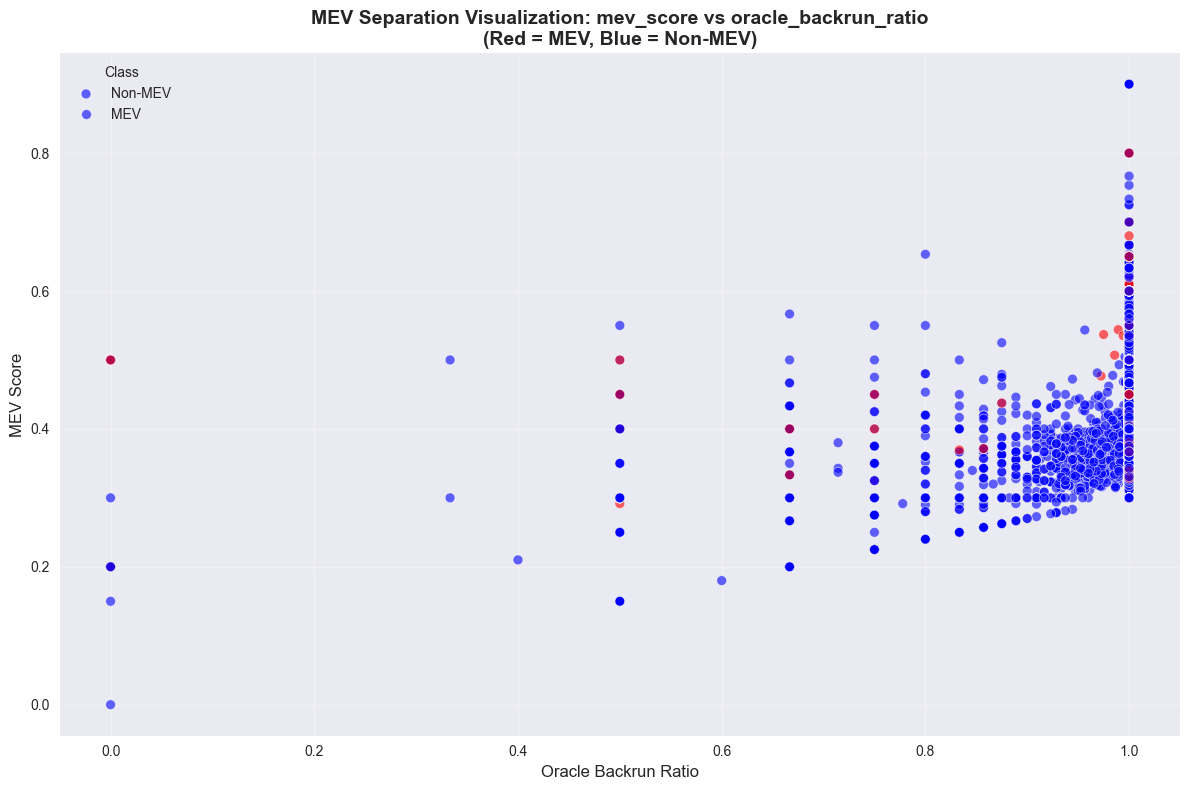


✓ Saved: derived/ml_results_binary/mev_separation_cluster.png


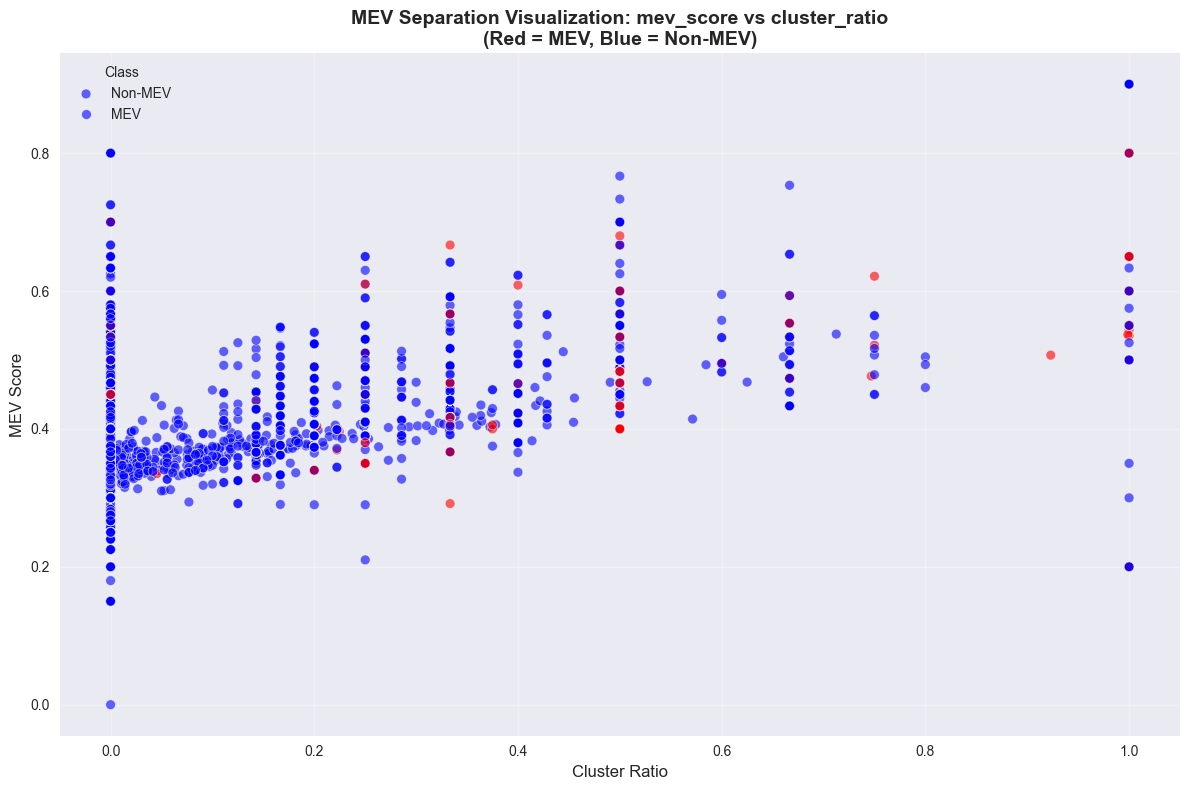

/var/folders/14/r1_gvf1n2_d9x603_nzns5xm0000gn/T/ipykernel_80986/239974833.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_data, x='Class', y='Mean', ax=ax, palette=['red', 'blue'])
/var/folders/14/r1_gvf1n2_d9x603_nzns5xm0000gn/T/ipykernel_80986/239974833.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_data, x='Class', y='Mean', ax=ax, palette=['red', 'blue'])
/var/folders/14/r1_gvf1n2_d9x603_nzns5xm0000gn/T/ipykernel_80986/239974833.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparis

✓ Saved: derived/ml_results_binary/mev_feature_comparison.png


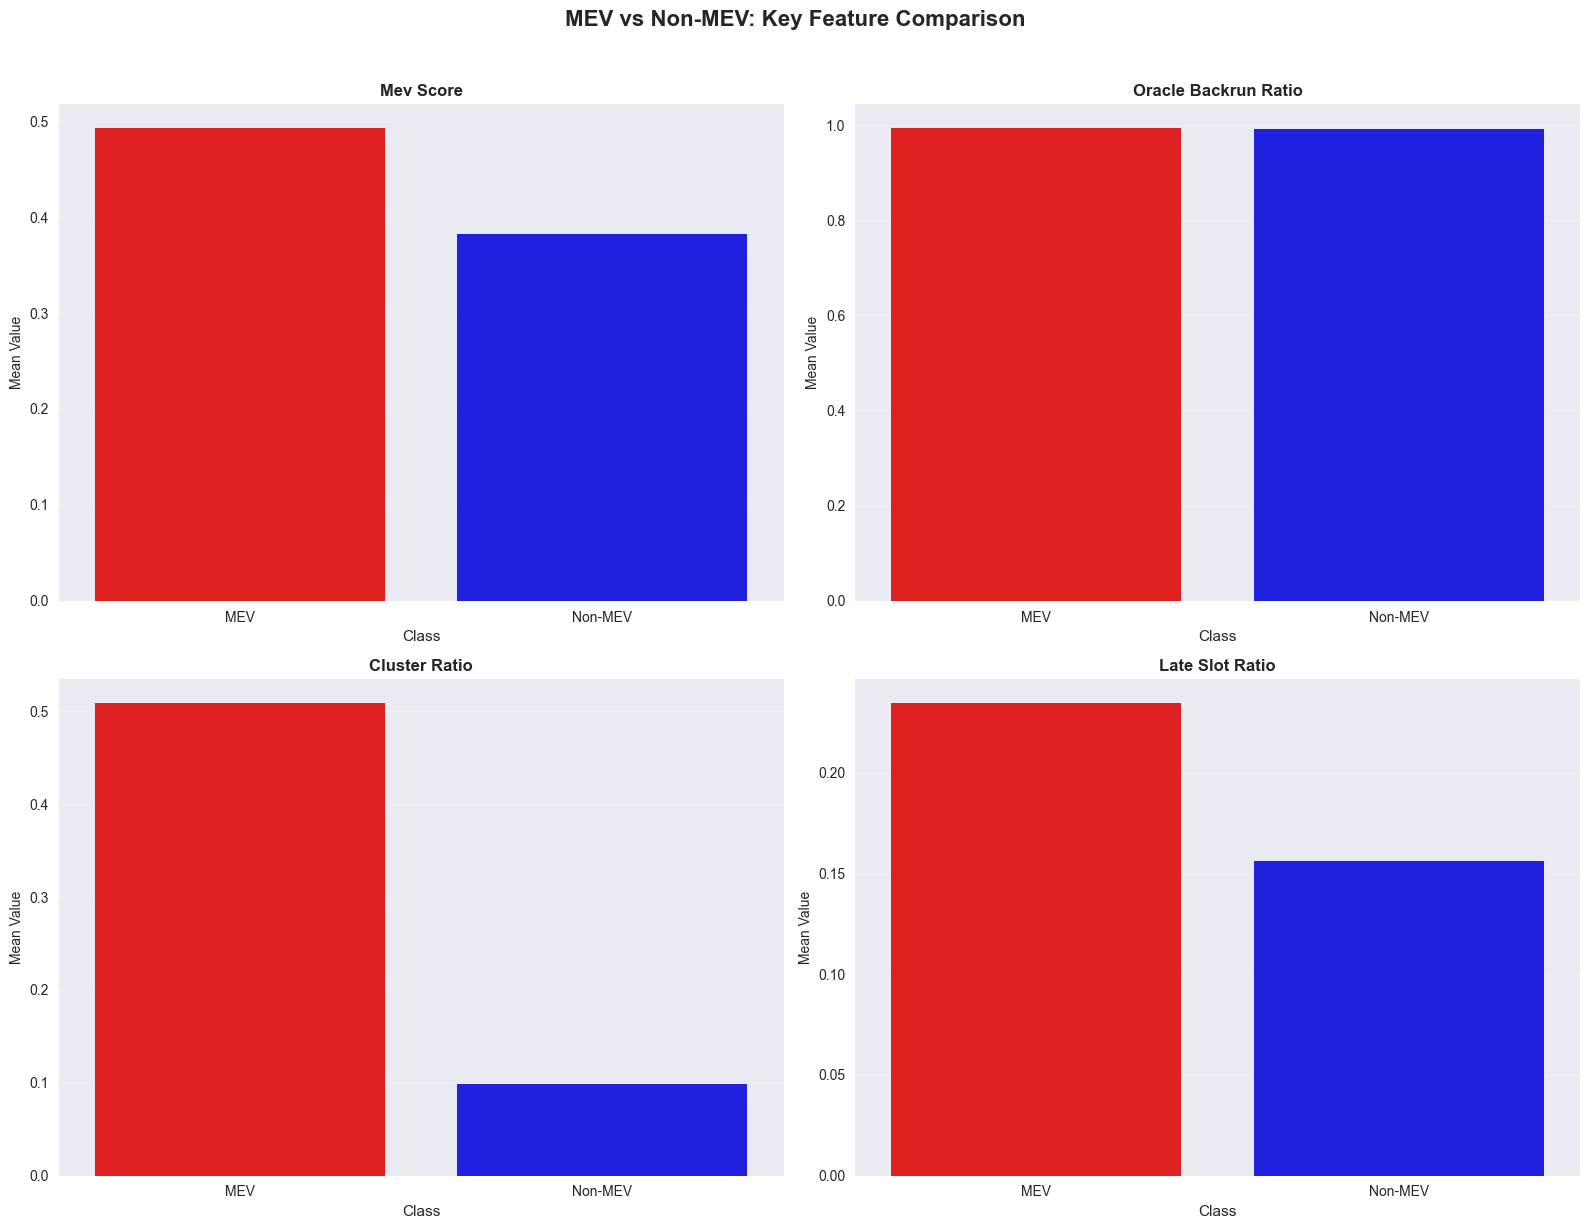

In [8]:
# ============================================================================
# 7. VISUALIZATIONS
# ============================================================================
print("="*80)
print("7. VISUALIZATIONS")
print("="*80)
print()

# Create output directory
output_dir = Path('derived/ml_results_binary')
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Scatter plot: mev_score vs oracle_backrun_ratio
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_features, 
    x='oracle_backrun_ratio', 
    y='mev_score', 
    hue='binary_label', 
    palette={0: 'blue', 1: 'red'}, 
    alpha=0.6,
    s=50
)
plt.title('MEV Separation Visualization: mev_score vs oracle_backrun_ratio\n(Red = MEV, Blue = Non-MEV)', fontsize=14, fontweight='bold')
plt.xlabel('Oracle Backrun Ratio', fontsize=12)
plt.ylabel('MEV Score', fontsize=12)
plt.legend(title='Class', labels=['Non-MEV', 'MEV'], fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'mev_separation_scatter.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir / 'mev_separation_scatter.png'}")
plt.show()
print()

# 2. Scatter plot: cluster_ratio vs mev_score
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_features, 
    x='cluster_ratio', 
    y='mev_score', 
    hue='binary_label', 
    palette={0: 'blue', 1: 'red'}, 
    alpha=0.6,
    s=50
)
plt.title('MEV Separation Visualization: mev_score vs cluster_ratio\n(Red = MEV, Blue = Non-MEV)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster Ratio', fontsize=12)
plt.ylabel('MEV Score', fontsize=12)
plt.legend(title='Class', labels=['Non-MEV', 'MEV'], fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'mev_separation_cluster.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir / 'mev_separation_cluster.png'}")
plt.show()
print()

# 3. Feature comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

features_to_plot = ['mev_score', 'oracle_backrun_ratio', 'cluster_ratio', 'late_slot_ratio']
for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 2, idx % 2]
    comparison_data = pd.DataFrame({
        'Class': ['MEV', 'Non-MEV'],
        'Mean': [mev_df[feature].mean(), non_mev_df[feature].mean()]
    })
    sns.barplot(data=comparison_data, x='Class', y='Mean', ax=ax, palette=['red', 'blue'])
    ax.set_title(f'{feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Value', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('MEV vs Non-MEV: Key Feature Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(output_dir / 'mev_feature_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir / 'mev_feature_comparison.png'}")
plt.show()
print()

In [9]:
# ============================================================================
# 8. EXPORT TO CSV
# ============================================================================
print("="*80)
print("8. EXPORT TO CSV")
print("="*80)
print()

# 1. All MEV samples
mev_export = mev_df.copy()
mev_csv_path = output_dir / 'mev_samples_detected.csv'
mev_export.to_csv(mev_csv_path, index=False)
print(f"✓ Exported {len(mev_export):,} MEV samples to: {mev_csv_path}")
print()

# 2. Top MEV wallets
top_mev_export = top_mev.copy()
top_mev_csv_path = output_dir / 'top_mev_wallets.csv'
top_mev_export.to_csv(top_mev_csv_path, index=False)
print(f"✓ Exported top {len(top_mev_export)} MEV wallets to: {top_mev_csv_path}")
print()

# 3. MEV statistics summary
stats_summary = {
    'Metric': [
        'Total_MEV_Samples',
        'Total_NonMEV_Samples',
        'MEV_Percentage',
        'MEV_Mean_mev_score',
        'NonMEV_Mean_mev_score',
        'MEV_Mean_oracle_backrun_ratio',
        'NonMEV_Mean_oracle_backrun_ratio',
        'MEV_Mean_cluster_ratio',
        'NonMEV_Mean_cluster_ratio',
        'Total_MEV_Trades',
        'Total_Unique_Validators',
        'Total_Unique_Pools'
    ],
    'Value': [
        len(mev_df),
        len(non_mev_df),
        len(mev_df)/len(df_features)*100,
        mev_df['mev_score'].mean(),
        non_mev_df['mev_score'].mean(),
        mev_df['oracle_backrun_ratio'].mean(),
        non_mev_df['oracle_backrun_ratio'].mean(),
        mev_df['cluster_ratio'].mean(),
        non_mev_df['cluster_ratio'].mean(),
        mev_df['total_trades'].sum(),
        len(validator_counts),
        len(pool_counts)
    ]
}

stats_df = pd.DataFrame(stats_summary)
stats_csv_path = output_dir / 'mev_statistics.csv'
stats_df.to_csv(stats_csv_path, index=False)
print(f"✓ Exported statistics to: {stats_csv_path}")
print()

# 4. Validator and Pool details
validator_df = pd.DataFrame({
    'validator': list(validator_counts.keys()),
    'mev_transaction_count': list(validator_counts.values())
}).sort_values('mev_transaction_count', ascending=False)

pool_df = pd.DataFrame({
    'pool_amm': list(pool_counts.keys()),
    'mev_transaction_count': list(pool_counts.values())
}).sort_values('mev_transaction_count', ascending=False)

validator_csv_path = output_dir / 'mev_validators.csv'
pool_csv_path = output_dir / 'mev_pools.csv'

validator_df.to_csv(validator_csv_path, index=False)
pool_df.to_csv(pool_csv_path, index=False)

print(f"✓ Exported validator info to: {validator_csv_path}")
print(f"✓ Exported pool info to: {pool_csv_path}")
print()

print("="*80)
print("EXTRACTION COMPLETE")
print("="*80)
print()
print(f"All results saved to: {output_dir}")
print(f"\nFiles created:")
print(f"  1. mev_samples_detected.csv - All {len(mev_df):,} MEV samples (with PnL estimates)")
print(f"  2. top_mev_wallets.csv - Top {len(top_mev_export)} MEV wallets")
print(f"  3. mev_statistics.csv - Summary statistics")
print(f"  4. mev_validators.csv - Validator information")
print(f"  5. mev_pools.csv - Pool/AMM information")
print(f"  6. mev_separation_scatter.png - Scatter plot visualization")
print(f"  7. mev_separation_cluster.png - Cluster ratio visualization")
print(f"  8. mev_feature_comparison.png - Feature comparison chart")
print()
print("Note: PnL estimates are based on attack pattern analysis.")
print("      Actual PnL would require parsing trade amounts and prices from trade data.")

8. EXPORT TO CSV

✓ Exported 2,318 MEV samples to: derived/ml_results_binary/mev_samples_detected.csv

✓ Exported top 20 MEV wallets to: derived/ml_results_binary/top_mev_wallets.csv

✓ Exported statistics to: derived/ml_results_binary/mev_statistics.csv

✓ Exported validator info to: derived/ml_results_binary/mev_validators.csv
✓ Exported pool info to: derived/ml_results_binary/mev_pools.csv

EXTRACTION COMPLETE

All results saved to: derived/ml_results_binary

Files created:
  1. mev_samples_detected.csv - All 2,318 MEV samples (with PnL estimates)
  2. top_mev_wallets.csv - Top 20 MEV wallets
  3. mev_statistics.csv - Summary statistics
  4. mev_validators.csv - Validator information
  5. mev_pools.csv - Pool/AMM information
  6. mev_separation_scatter.png - Scatter plot visualization
  7. mev_separation_cluster.png - Cluster ratio visualization
  8. mev_feature_comparison.png - Feature comparison chart

Note: PnL estimates are based on attack pattern analysis.
      Actual PnL woul